# Libraries & Settings

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [2]:
print(pd.__version__)
print(np.version.version)
print(sys.version)

1.0.5
1.18.5
3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


In [3]:
!pip install lightgbm

In [4]:
mpl.matplotlib_fname()
plt.rc('font', size=15)        # basic fond
plt.rc('axes', labelsize=25)   # x/y labels
plt.rc('xtick', labelsize=20)  # x-axis grid
plt.rc('ytick', labelsize=20)  # y-axis grid
plt.rc('legend', fontsize=15) 
plt.rc('figure', titlesize=20)

# Acquire Data

In [5]:
df_test = pd.read_csv("./Data/test.csv")
df_train = pd.read_csv("./Data/train.csv")

In [6]:
df_train.tail()

PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q

### Comparing Columns

In [7]:
df_train.info()
print('_'*40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [8]:
# find different column
train_columns = pd.DataFrame({"Diff_Column": df_train.columns,
                            "train_data" : range(len(df_train.columns.tolist()))})

test_columns = pd.DataFrame({'Diff_Column': df_test.columns, 
                             'test_data': range(len(df_test.columns.tolist()))})

col_merged = pd.merge(train_columns, test_columns, on = 'Diff_Column', how = 'left') # compare by column name

diff_columns = []
for i in col_merged[col_merged.isnull().any(axis = 1)]['Diff_Column']:
    diff_columns.append(i)

In [9]:
# Change Column

re_index = list(df_test.columns)

for col in df_train.columns:
    if col in diff_columns :
        re_index.append(col)
        
df_train = df_train.reindex(columns = re_index)


In [10]:
df_train.tail()

PassengerId  Pclass                                      Name     Sex  \
886          887       2                     Montvila, Rev. Juozas    male   
887          888       1              Graham, Miss. Margaret Edith  female   
888          889       3  Johnston, Miss. Catherine Helen "Carrie"  female   
889          890       1                     Behr, Mr. Karl Howell    male   
890          891       3                       Dooley, Mr. Patrick    male   

      Age  SibSp  Parch      Ticket   Fare Cabin Embarked  Survived  
886  27.0      0      0      211536  13.00   NaN        S         0  
887  19.0      0      0      112053  30.00   B42        S         1  
888   NaN      1      2  W./C. 6607  23.45   NaN        S         0  
889  26.0      0      0      111369  30.00  C148        C         1  
890  32.0      0      0      370376   7.75   NaN        Q         0

In [11]:
train_info = pd.DataFrame(zip(df_train.columns, df_train.count(),df_train.nunique(), df_train.dtypes))
train_info.columns = ['Column', 'Count', 'Unique', 'Dtype']
test_info = pd.DataFrame(zip(df_test.columns, df_test.count(), df_test.nunique(), df_test.dtypes))
test_info.columns = ['Column', 'Count', 'Unique', 'Dtype']
pd.concat([train_info, test_info], axis = 1, join ='outer',
          keys = ['train info','test info'])#.reindex=[train_info.index]

train info                          test info                       
         Column Count Unique    Dtype       Column  Count Unique    Dtype
0   PassengerId   891    891    int64  PassengerId  418.0  418.0    int64
1        Pclass   891      3    int64       Pclass  418.0    3.0    int64
2          Name   891    891   object         Name  418.0  418.0   object
3           Sex   891      2   object          Sex  418.0    2.0   object
4           Age   714     88  float64          Age  332.0   79.0  float64
5         SibSp   891      7    int64        SibSp  418.0    7.0    int64
6         Parch   891      7    int64        Parch  418.0    8.0    int64
7        Ticket   891    681   object       Ticket  418.0  363.0   object
8          Fare   891    248  float64         Fare  417.0  169.0  float64
9         Cabin   204    147   object        Cabin   91.0   76.0   object
10     Embarked   889      3   object     Embarked  418.0    3.0   object
11     Survived   891      2    int64          NaN    NaN    NaN      NaN

# Data Processing

### Categorization

In [12]:
df_train.describe()

PassengerId      Pclass         Age       SibSp       Parch  \
count   891.000000  891.000000  714.000000  891.000000  891.000000   
mean    446.000000    2.308642   29.699118    0.523008    0.381594   
std     257.353842    0.836071   14.526497    1.102743    0.806057   
min       1.000000    1.000000    0.420000    0.000000    0.000000   
25%     223.500000    2.000000   20.125000    0.000000    0.000000   
50%     446.000000    3.000000   28.000000    0.000000    0.000000   
75%     668.500000    3.000000   38.000000    1.000000    0.000000   
max     891.000000    3.000000   80.000000    8.000000    6.000000   

             Fare    Survived  
count  891.000000  891.000000  
mean    32.204208    0.383838  
std     49.693429    0.486592  
min      0.000000    0.000000  
25%      7.910400    0.000000  
50%     14.454200    0.000000  
75%     31.000000    1.000000  
max    512.329200    1.000000

In [13]:
df_train.describe(include=["O"])

Name   Sex Ticket        Cabin Embarked
count                   891   891    891          204      889
unique                  891     2    681          147        3
top     Robbins, Mr. Victor  male   1601  C23 C25 C27        S
freq                      1   577      7            4      644

In [14]:
train_visual = df_train.select_dtypes(
                     include = ['object', 'category']).columns.tolist()
train_visual

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [15]:
uniques = {col : df_test[col].nunique() for col in df_test.columns}

In [16]:
uniques

{'PassengerId': 418,
 'Pclass': 3,
 'Name': 418,
 'Sex': 2,
 'Age': 79,
 'SibSp': 7,
 'Parch': 8,
 'Ticket': 363,
 'Fare': 169,
 'Cabin': 76,
 'Embarked': 3}

In [17]:
category_list = []
# categorization SibSp, Parch
for col in uniques :
    if uniques[col] <= 10 : category_list.append(col)

In [18]:
category_list

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [19]:
for col in category_list :
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [20]:
def transform_index(data, columns) :
    for col in columns :
        cnt = 0
        dicts = dict()
        cols = data[col]
        for idx in range(len(data[col])):
            if data[col][idx] in dicts : continue
            dicts[data[col][idx]] = cnt
            cnt += 1
        data.drop(col,axis=1,inplace=True)
        lists = []
        for i in range(len(cols)):
            lists.append(dicts[cols[i]])
        data[col] = lists


In [21]:
transform_index(df_train,category_list)
transform_index(df_test,category_list)

## Missing Value

In [22]:
round((df_train.isnull().sum()/len(df_train)*100).sort_values(ascending=False),1)

Cabin          77.1
Age            19.9
Embarked        0.0
Parch           0.0
SibSp           0.0
Sex             0.0
Pclass          0.0
Survived        0.0
Fare            0.0
Ticket          0.0
Name            0.0
PassengerId     0.0
dtype: float64

In [23]:
round((df_test.isnull().sum()/len(df_test)*100).sort_values(ascending=False),1)

Cabin          78.2
Age            20.6
Fare            0.2
Embarked        0.0
Parch           0.0
SibSp           0.0
Sex             0.0
Pclass          0.0
Ticket          0.0
Name            0.0
PassengerId     0.0
dtype: float64

### Cabin

In [24]:
df_train.drop("Cabin", axis=1, inplace=True)
df_test.drop("Cabin", axis=1, inplace=True)

### Age

In [25]:
def sub_plots(x_list, y_val, df):
    if len(x_list) < 5 : rows, cols = 2,2
    else : rows, cols = 2, 3
    
    figure, axes = plt.subplots(nrows=rows, ncols=cols)
    figure.set_size_inches(20,12)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            sns.barplot(data=df, x=x_list[idx], y=y_val, ax=axes[i][j])
            idx += 1
            if idx == len(x_list) : return

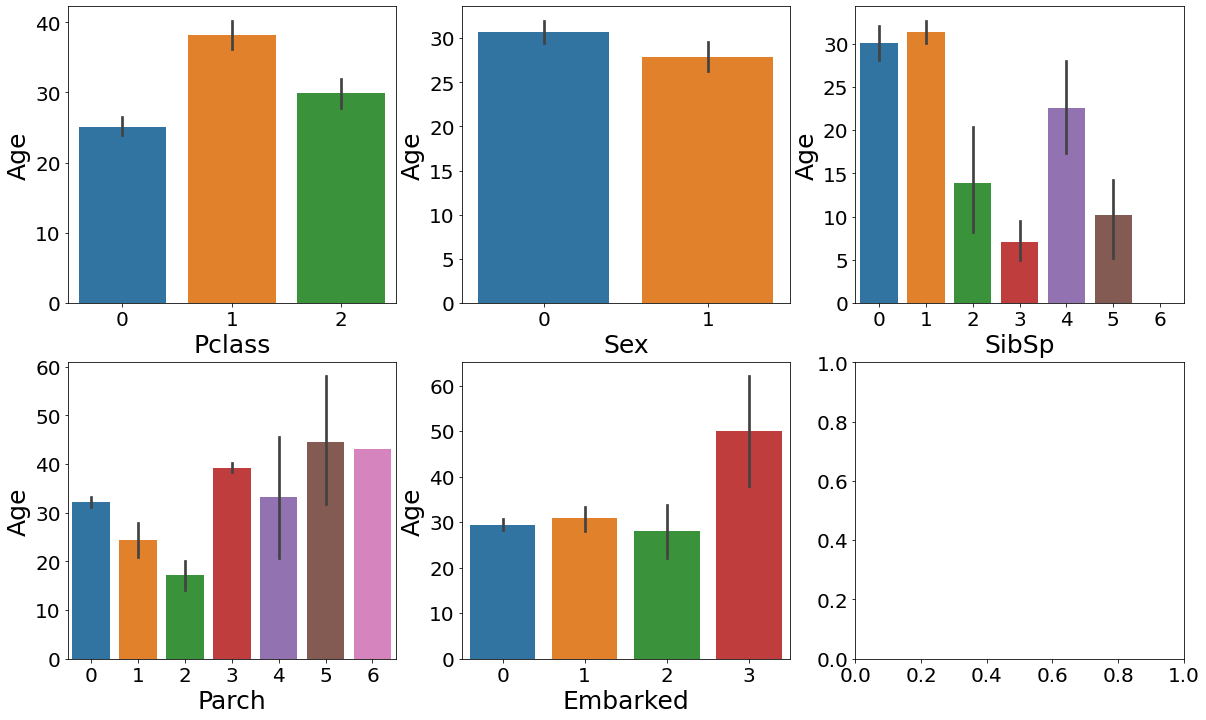

In [26]:
sub_plots(category_list,"Age",df_train)

In [27]:
#PClass / Sex

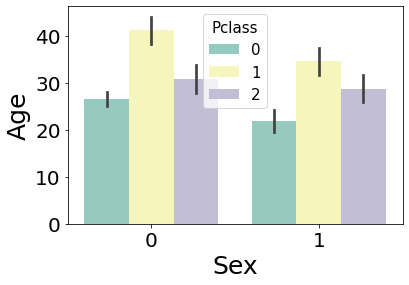

In [28]:
sns.barplot(x = 'Sex', y = 'Age',data=df_train,
            hue='Pclass', palette='Set3')

In [29]:
Age_count = pd.DataFrame({'count': df_train.groupby(['Pclass', 'Sex']).size()})

Age_mean_std = round(pd.pivot_table(df_train, 
                              index = ['Pclass', 'Sex'], 
                              values = 'Age', aggfunc = (np.mean, np.std)), 0)

Age_count.join(Age_mean_std, how = 'outer')

count  mean   std
Pclass Sex                   
0      0      347  27.0  12.0
       1      144  22.0  13.0
1      0      122  41.0  15.0
       1       94  35.0  14.0
2      0      108  31.0  15.0
       1       76  29.0  13.0

In [30]:
def filled_Age_value(data):
    for pclass in [0, 1, 2]:
        for sex in [0, 1]:
            value = data[(data['Pclass']==pclass) & (data['Sex']==sex)]['Age'].median()
            null_list = []
            for index, nan in data[(data['Pclass']==pclass) & (data['Sex']==sex)]['Age'].isnull().items():
                if nan==True:
                    null_list.append(index)
            data.loc[null_list, 'Age'] = value

In [31]:
filled_Age_value(df_train)
filled_Age_value(df_test)

### Embarked

In [32]:
df_train[df_train["Embarked"].isnull()]

Empty DataFrame
Columns: [PassengerId, Name, Age, Ticket, Fare, Survived, Pclass, Sex, SibSp, Parch, Embarked]
Index: []

In [33]:
delete_rows = [61,829]

In [34]:
#df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace = True)
# Just 2 rows
df_train.drop(delete_rows, inplace=True)

In [35]:
df_test[df_test["Embarked"].isnull()]

Empty DataFrame
Columns: [PassengerId, Name, Age, Ticket, Fare, Pclass, Sex, SibSp, Parch, Embarked]
Index: []

### Fare

In [36]:
df_train[df_train["Fare"].isnull()]

Empty DataFrame
Columns: [PassengerId, Name, Age, Ticket, Fare, Survived, Pclass, Sex, SibSp, Parch, Embarked]
Index: []

In [37]:
df_test[df_test["Fare"].isnull()]

PassengerId                Name   Age Ticket  Fare  Pclass  Sex  SibSp  \
152         1044  Storey, Mr. Thomas  60.5   3701   NaN       0    0      0   

     Parch  Embarked  
152      0         1

In [38]:
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace = True)

## EDA

### Heatmap

In [39]:
st = df_train.apply(LabelEncoder().fit_transform)

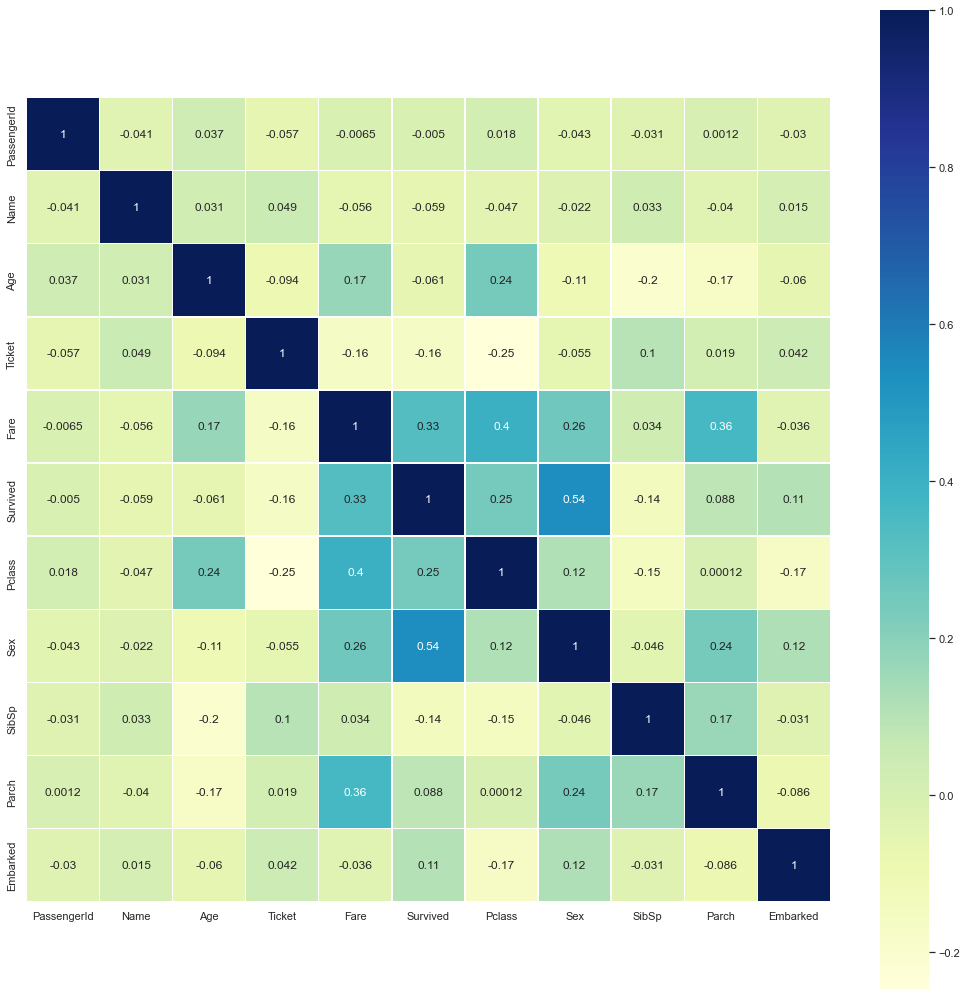

In [40]:
sns.set(color_codes=True)
plt.figure(figsize=(18, 18))

sns.heatmap(st.astype(float).corr(), 
            linewidths=0.2, 
            square=True, 
            linecolor='white', 
            annot=True,
            cmap="YlGnBu"
           )
plt.show()

### Remove Columns

In [41]:
test_passengerid = df_test["PassengerId"]
# PassengerId
df_train.drop('PassengerId', axis = 1, inplace = True)
df_test.drop('PassengerId', axis = 1, inplace = True)
# Name
df_train.drop('Name', axis = 1, inplace = True)
df_test.drop('Name', axis = 1, inplace = True)

In [42]:
eda_columns = df_train.select_dtypes(
                     include = ['int','object', 'category']).columns.tolist()
eda_columns

['Ticket', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [43]:
# delete numeric columns
eda_columns.remove('Ticket')
eda_columns.remove("Survived")

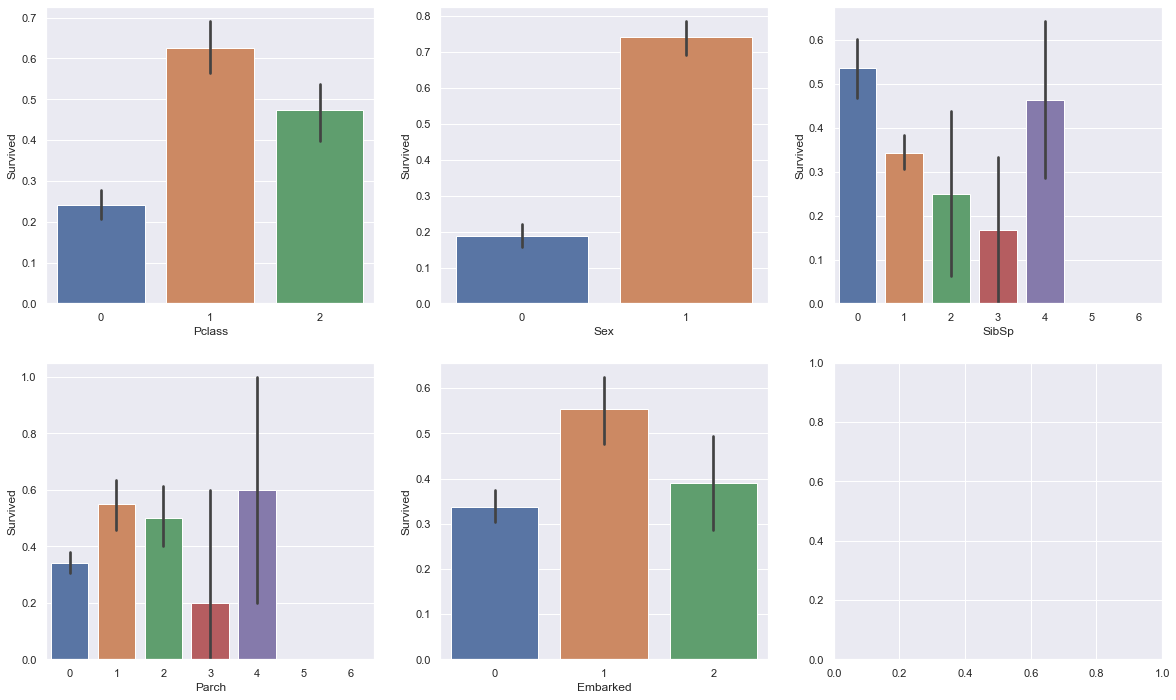

In [44]:
sub_plots(eda_columns,"Survived",df_train)

In [45]:
df_train["Family"] = df_train["SibSp"].astype(int) + df_train["Parch"].astype(int) + 1
df_test["Family"] = df_test["SibSp"].astype(int) + df_test["Parch"].astype(int) + 1

In [46]:
df_train.drop("SibSp",axis=1,inplace=True)
df_test.drop("SibSp",axis=1,inplace=True)
df_train.drop("Parch",axis=1,inplace=True)
df_test.drop("Parch",axis=1,inplace=True)
eda_columns.pop(eda_columns.index("SibSp"))
eda_columns.pop(eda_columns.index("Parch"))
eda_columns.append("Family")

In [47]:
eda_columns

['Pclass', 'Sex', 'Embarked', 'Family']

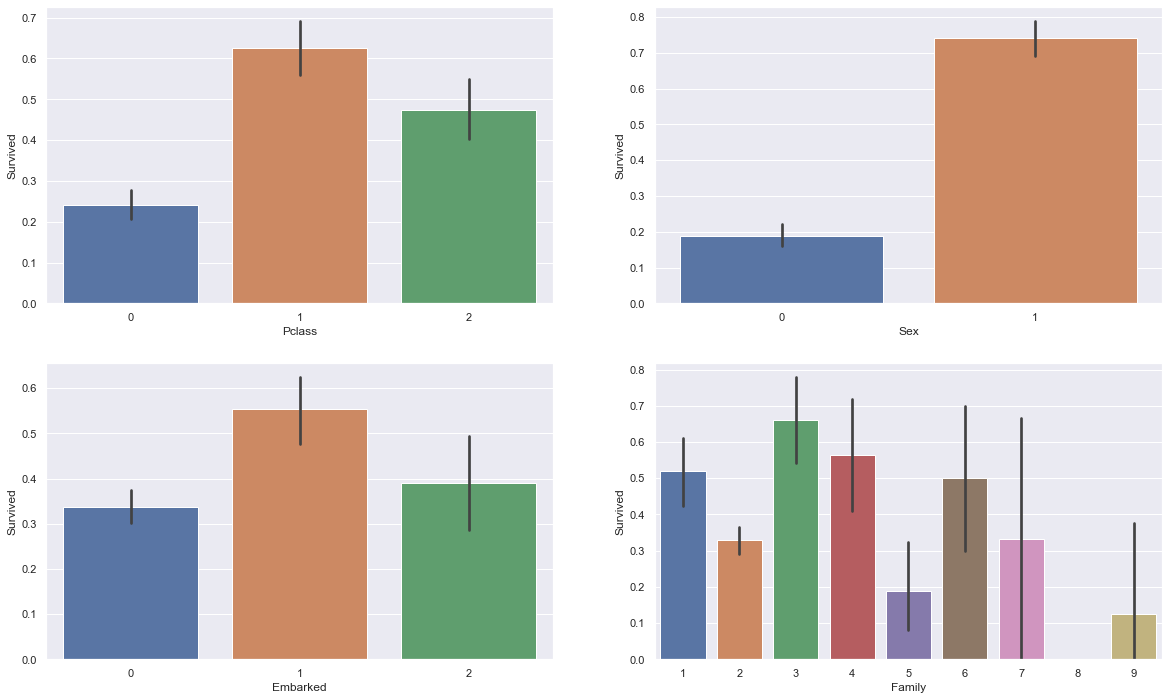

In [48]:
sub_plots(eda_columns,"Survived",df_train)

In [49]:
df_train.head()

Age            Ticket     Fare  Survived  Pclass  Sex  Embarked  Family
0  22.0         A/5 21171   7.2500         0       0    0         0       1
1  38.0          PC 17599  71.2833         1       1    1         1       1
2  26.0  STON/O2. 3101282   7.9250         1       0    1         0       2
3  35.0            113803  53.1000         1       1    1         0       1
4  35.0            373450   8.0500         0       0    0         0       2

In [50]:
### Same accommodation
tr_ticket_cnt_dict = dict(df_train.groupby('Ticket').size())
te_ticket_cnt_dict = dict(df_test.groupby("Ticket").size())

In [51]:
df_train['ticket_cnt'] = df_train['Ticket'].map(tr_ticket_cnt_dict)
df_test['ticket_cnt'] = df_test["Ticket"].map(te_ticket_cnt_dict)

In [52]:
df_train.head()

Age            Ticket     Fare  Survived  Pclass  Sex  Embarked  Family  \
0  22.0         A/5 21171   7.2500         0       0    0         0       1   
1  38.0          PC 17599  71.2833         1       1    1         1       1   
2  26.0  STON/O2. 3101282   7.9250         1       0    1         0       2   
3  35.0            113803  53.1000         1       1    1         0       1   
4  35.0            373450   8.0500         0       0    0         0       2   

   ticket_cnt  
0           1  
1           1  
2           1  
3           2  
4           1

In [53]:
df_train.drop("Ticket",axis=1, inplace=True)
df_test.drop("Ticket",axis=1, inplace=True)

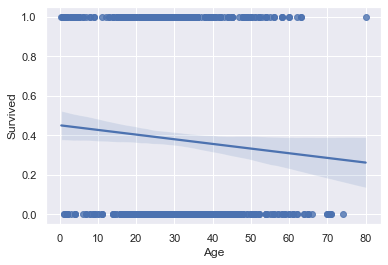

In [54]:
# Age ratio
age_ratio = sns.regplot(x='Age',y='Survived',data=df_train ) 

## Normalization

In [55]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
scaler = MinMaxScaler()

In [57]:
df_train[:] = scaler.fit_transform(df_train[:])
df_test[:] = scaler.fit_transform(df_test[:])

In [58]:
df_train.head()

Age      Fare  Survived  Pclass  Sex  Embarked  Family  ticket_cnt
0  0.271174  0.014151       0.0     0.0  0.0       0.0   0.000    0.000000
1  0.472229  0.139136       1.0     0.5  1.0       0.5   0.000    0.000000
2  0.321438  0.015469       1.0     0.0  1.0       0.0   0.125    0.000000
3  0.434531  0.103644       1.0     0.5  1.0       0.0   0.000    0.166667
4  0.434531  0.015713       0.0     0.0  0.0       0.0   0.125    0.000000

## Train_test Split & Visualization Function¶

In [59]:
dataset_x= df_train.copy()
dataset_y = dataset_x.pop('Survived')

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [61]:
def regression_data():
    X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y,)
    return X_train, y_train, X_test, y_test

def calculate_r2_score(y_tes, y_pre):
    print('RMSE:', mean_squared_error(y_tes, y_pre) ** 0.5)
    print('R2_score :', r2_score(y_tes, y_pre) ** 0.5)

### Decision Tree

In [62]:
val = 1000000000

In [63]:
X_train, y_train, X_test, y_test = regression_data()

In [64]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(666, 7) (223, 7) (666,) (223,)


In [65]:
from sklearn.tree import DecisionTreeRegressor
X_train, y_train, X_test, y_test = regression_data()

decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
# Evaluation
y_pred = decision_tree.predict(X_test)

In [66]:
calculate_r2_score(y_test, y_pred)

RMSE: 0.43672988229595616
R2_score : 0.47509733789368985


### Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=2000)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

In [68]:
calculate_r2_score(y_test, y_pred)

RMSE: 0.4287849137296606
R2_score : 0.5036195519052299


In [69]:
df_train

Age      Fare  Survived  Pclass  Sex  Embarked  Family  ticket_cnt
0    0.271174  0.014151       0.0     0.0  0.0       0.0   0.000    0.000000
1    0.472229  0.139136       1.0     0.5  1.0       0.5   0.000    0.000000
2    0.321438  0.015469       1.0     0.0  1.0       0.0   0.125    0.000000
3    0.434531  0.103644       1.0     0.5  1.0       0.0   0.000    0.166667
4    0.434531  0.015713       0.0     0.0  0.0       0.0   0.125    0.000000
..        ...       ...       ...     ...  ...       ...     ...         ...
886  0.334004  0.025374       0.0     1.0  0.0       0.0   0.125    0.000000
887  0.233476  0.058556       1.0     0.5  1.0       0.0   0.125    0.000000
888  0.264891  0.045771       0.0     0.0  1.0       0.0   0.250    0.166667
889  0.321438  0.058556       1.0     0.5  0.0       0.5   0.125    0.000000
890  0.396833  0.015127       0.0     0.0  0.0       1.0   0.125    0.000000

[889 rows x 8 columns]

In [70]:
res = decision_tree.predict(df_test.values).astype(int)
res = random_forest.predict(df_test.values).astype(int)

In [71]:
df_test["PassengerId"] = test_passengerid

In [72]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': res})
output.to_csv('submission.csv', index=False)